4.999999999999916
Simulation completed in 16.63 seconds.


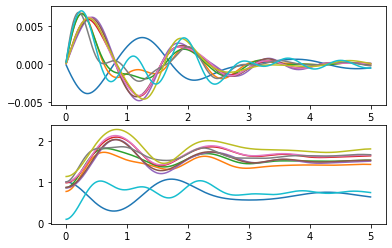

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import dynpssimpy.dynamic as dps
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import RK23, RK45, solve_ivp
import importlib
import time

from IPython.display import clear_output, display


# Load model
# import ps_models.k2a as model_data
import ps_models.ieee39 as model_data
# import ps_models.n44 as model_data

[importlib.reload(mdl) for mdl in [dps, model_data]]
model = model_data.load()

t_0 = time.time()

ps = dps.PowerSystemModel(model=model)
ps.pf_max_it = 100
# ps.use_numba = True
ps.power_flow()
ps.init_dyn_sim()
ps.build_y_bus_red()
ps.ode_fun(0.0, ps.x0)
t_end = 5
x0 = ps.x0.copy()
x0[ps.gen_mdls['GEN'].state_idx['angle'][0]] += 1

sol = RK45(ps.ode_fun, 0, x0, t_end, max_step=5e-3)

t = 0
result_dict = defaultdict(list)

while t < t_end:
    clear_output(wait=True)
    print(t)

    # Simulate next step
    result = sol.step()
    x = sol.y
    t = sol.t

    # Store result
    result_dict['Global', 't'].append(sol.t)
    [result_dict[tuple(desc)].append(state) for desc, state in zip(ps.state_desc, x)]

print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

index = pd.MultiIndex.from_tuples(result_dict)
result = pd.DataFrame(result_dict, columns=index)

fig, ax = plt.subplots(2)
ax[0].plot(result[('Global', 't')], result.xs(key='speed', axis='columns', level=1))
ax[1].plot(result[('Global', 't')], result.xs(key='angle', axis='columns', level=1))
plt.show()

